# 0. Setup

In [3]:
import os
import pickle
import time
from functools import reduce, partial

# import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import jax
# jax.config.update("jax_enable_x64", True)
from jax import random, vmap, jit, grad
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
from numpyro.infer.inspect import render_model

from kernels import ARWMH, ARWMHAdaptState, ARWMHState, NUTS, ASSS, ASSSAdaptState
from utils.evaluation import wasserstein_1d, wasserstein_dist11_p
from utils.lipschitz import compute_wasserstein_contraction, compute_kernel_distance, compute_kernel_distance_1d

In [4]:
# svg_dir = os.path.join(os.environ["MCMC_WORKDIR"], "img/svg/")
svg_dir = "../../img/svg"

# 1. Univariate distribution

In [3]:
normal_dist = dist.Normal(0, 1)
potential_fn = lambda x: -1 *normal_dist.log_prob(x)

kernel_rwm_normal = ARWMH(potential_fn=potential_fn)
# kernel_sa_normal = SA(potential_fn=potential_fn)
kernel_sss_normal = ASSS(potential_fn=potential_fn)
kernel_nuts_normal = NUTS(potential_fn=potential_fn)

In [4]:
def get_arwm_adapt_state(scale=1.0):
    return ARWMHAdaptState(
        loc=jnp.array([0.0]),
        scale=jnp.array([[scale]]),
        log_step_size=jnp.array(0)
    )


In [5]:
rng_key = random.PRNGKey(0)

rwm_s1 = get_arwm_adapt_state(1.0)
rwm_s2 = get_arwm_adapt_state(0.5)
rwm_s3 = get_arwm_adapt_state(5.0)

sample_dist1 = dist.MultivariateNormal(loc=rwm_s1.loc, scale_tril=jnp.exp(rwm_s1.log_step_size)*rwm_s1.scale)
sample_dist2 = dist.MultivariateNormal(loc=rwm_s2.loc, scale_tril=jnp.exp(rwm_s1.log_step_size)*rwm_s2.scale)
sample_dist3 = dist.MultivariateNormal(loc=rwm_s3.loc, scale_tril=jnp.exp(rwm_s1.log_step_size)*rwm_s3.scale)

In [6]:
sss_s1 = ASSSAdaptState(jnp.array([0.]), jnp.array([[1.]]))
sss_s2 = ASSSAdaptState(jnp.array([0.]), jnp.array([[0.1]]))
sss_s3 = ASSSAdaptState(jnp.array([0.]), jnp.array([[10.]]))

sss_s4 = ASSSAdaptState(jnp.array([1.]), jnp.array([[1.]]))
sss_s5 = ASSSAdaptState(jnp.array([1.]), jnp.array([[0.1]]))
sss_s6 = ASSSAdaptState(jnp.array([1.]), jnp.array([[10.]]))

In [7]:
init_params = jnp.array(0.0)
sss_init = kernel_sss_normal.get_init_adapt_state(rng_key, init_params)
nuts_init = kernel_nuts_normal.get_init_adapt_state(rng_key, init_params)

In [7]:
x_dist = jnp.arange(-5, 5, .002)
# plt.hist(mcmc.get_samples(), bins=50, density=True, label="samples")

# plt.plot(x_dist, jnp.exp(normal_dist.log_prob(x_dist)), color="green", label=r"target $\pi$")

plt.plot(x_dist, jnp.exp(vmap(sample_dist2.log_prob)(x_dist)), color='orange', label=r"$\sigma = 0.5$")
plt.plot(x_dist, jnp.exp(vmap(sample_dist1.log_prob)(x_dist)), color='blue', label=r"$\sigma = 1$")
plt.plot(x_dist, jnp.exp(vmap(sample_dist3.log_prob)(x_dist)), color='red', label=r"$\sigma = 5$")

plt.ylabel("density")
plt.xlabel(r"$x$")
plt.legend()
# plt.savefig(svg_dir + "normal-density.svg", format="svg")

NameError: name 'sample_dist2' is not defined

## 1.1. Accept rates


In [9]:
# adapt_state = get_adapt_state(1.0)
scale = 1.0
def alpha(x, z):
    Ux = -normal_dist.log_prob(x)
    Uxz = -normal_dist.log_prob(x + scale * z)
    acc_prob = jnp.clip(jnp.exp(Ux - Uxz), max=1)
    
    return acc_prob

In [10]:
rng_key = random.PRNGKey(0)
z_samples = normal_dist.sample(rng_key, sample_shape=(10000,))

@jit
def next_m(x):
    alphas = vmap(alpha, in_axes=(None, 0))(x, z_samples)
    step = jnp.mean(z_samples * alphas)
    return x + step

def alpha_m(x):
    return vmap(alpha, in_axes=(None, 0))(x, z_samples).mean(axis=0)

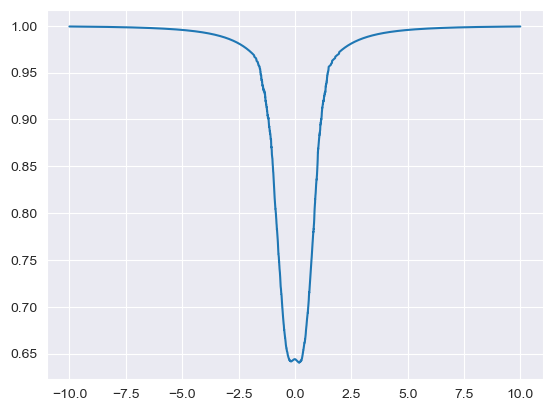

In [12]:
x = jnp.arange(-10, 10, .002)
plt.plot(x, vmap(grad(next_m))(x))

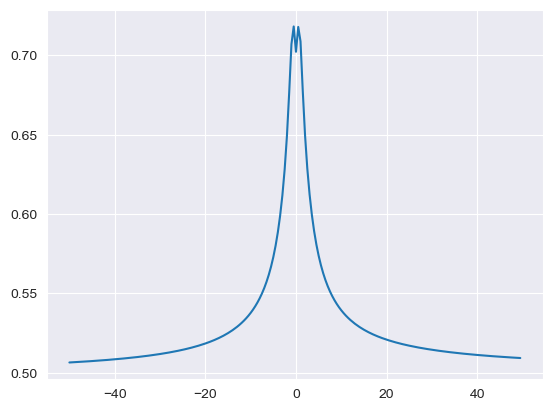

In [13]:
x = jnp.arange(-50, 50, 0.5)
plt.plot(x, vmap(alpha_m)(x))

## 1.2. Sampling from $P(x, \cdot)$

In [11]:
rng_key = random.PRNGKey(0)
x = jnp.linspace(-5, 5, 100)

In [12]:
%%time 

N = 100000

# P1x = kernel_sss_normal.sample_Pnx(rng_key, x, sss_s4, n=5, n_samples=N)
P1x = kernel_rwm_normal.sample_Pnx(rng_key, x, rwm_s1, n=5, n_samples=N)

print(P1x.mean())

-0.0004651045
CPU times: user 7.87 s, sys: 421 ms, total: 8.3 s
Wall time: 2.28 s


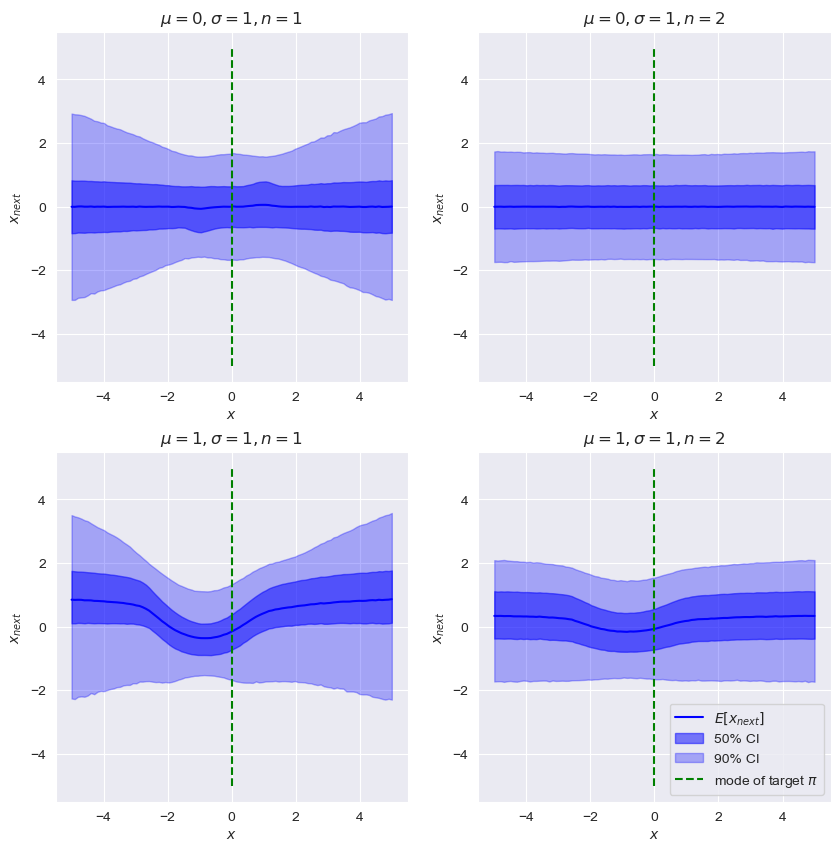

In [39]:
x = jnp.linspace(-5, 5, 100)
fig, axs = plt.subplots(2,2, sharex=False, sharey=False, figsize=(10,10))

for loc, _axs in zip([0, 1], axs):
    if loc == 0:
        a_s = sss_s1
    else:
        a_s = sss_s4
    
    for n, ax1 in zip([1, 2], _axs):
        Px = kernel_sss_normal.sample_Pnx(rng_key, x, a_s, n=n, n_samples=int(1e5))
        
        Px_mean = Px.mean(axis=1) 
        P1x_low = jnp.quantile(Px, 0.25, axis=1)
        P1x_up = jnp.quantile(Px, 0.75, axis=1)
        P1x_lower = jnp.quantile(Px, 0.05, axis=1)
        P1x_upper = jnp.quantile(Px, 0.95, axis=1)
        
        ax1.set_title(rf"$\mu={loc}, \sigma=1, n={n}$")
        
        ax1.plot(x, Px_mean, color='blue', label="$E[x_{next}]$")
        ax1.fill_between(x, P1x_low, P1x_up, alpha=0.5, color="blue", label="50% CI")
        ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
        
        # ax1.plot(x, x, '--', color="gray", label=r"$x=x_{next}$")
        ax1.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
        
        ax1.set_ylabel("$x_{next}$")
        ax1.set_xlabel("$x$")
        
    # fig.savefig(svg_dir + f"sss-normal-x-step-m{loc}-s1-n{n}.svg", format="svg")
    
axs[1,1].legend(loc="lower right") # bbox_to_anchor=(0.15, 0.9)
# plt.tight_layout()
    
fig.savefig(svg_dir + f"sss-normal-x-step-m01-s1.svg", format="svg")

In [132]:
N = 100000

# P1x = kernel_rwm_normal.sample_Pnx(rng_key, x, rwm_s1, n=1, n_samples=N)
# P2x = kernel_rwm_normal.sample_Pnx(rng_key, x, rwm_s2, n=1, n_samples=N)
# P3x = kernel_rwm_normal.sample_Pnx(rng_key, x, rwm_s3, n=1, n_samples=N)
# 
P1x = kernel_sss_normal.sample_Pnx(rng_key, x, sss_s4, n=1, n_samples=N)
P2x = kernel_sss_normal.sample_Pnx(rng_key, x, sss_s5, n=1, n_samples=N)
P3x = kernel_sss_normal.sample_Pnx(rng_key, x, sss_s6, n=1, n_samples=N)

In [133]:
normal_samples = normal_dist.sample(rng_key, sample_shape=(N,))
@jit
def ecc_normal(x):
    return jnp.abs(normal_samples[None] - x[:, None]).mean(axis=1)

def Wx_normal(Px_samples):
    return wasserstein_1d(normal_samples, Px_samples)

Ex = ecc_normal(x)

WP1x = vmap(Wx_normal)(P1x)
WP2x = vmap(Wx_normal)(P2x)
WP3x = vmap(Wx_normal)(P3x)

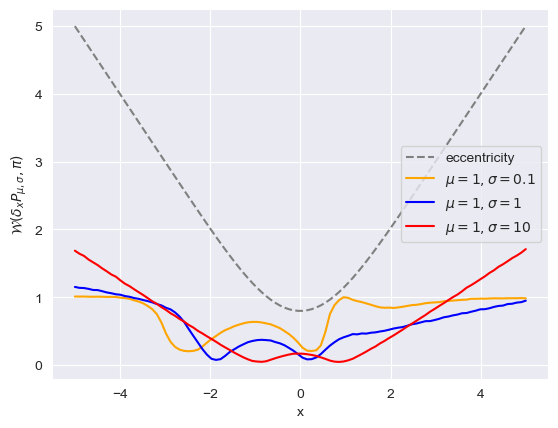

In [135]:
fig, ax = plt.subplots()
# ax.set_title(r"$\sigma^2=1, n=1$")

ax.plot(x, Ex, "--", label="eccentricity", color="gray")
ax.plot(x, WP2x, label=r"$\mu=1, \sigma = 0.1$", color="orange")
ax.plot(x, WP1x, label=r"$\mu=1, \sigma = 1$", color="blue")
ax.plot(x, WP3x, label=r"$\mu=1, \sigma = 10$", color="red")

# ax.plot(x, EPx_mean, color="blue", label="mean")
# 
# ax.fill_between(x, EPx_low, EPx_up, lr_rate=0.5, color="blue", label="50% CI")
# ax.fill_between(x, EPx_lower, EPx_upper, lr_rate=0.3, color="blue", label="90% CI")

# ax.plot([Ex.min(), Ex.max()], [Ex.min(), Ex.max()], '--', color="gray", label="y=x")
ax.legend(loc="center right")

ax.set_xlabel("x")
ax.set_ylabel(r"$\mathcal{W}(\delta_x P_{\mu, \sigma}, \pi)$")

# fig.savefig(svg_dir + "sss-normal-x-wasserstein-m1.svg", format="svg")

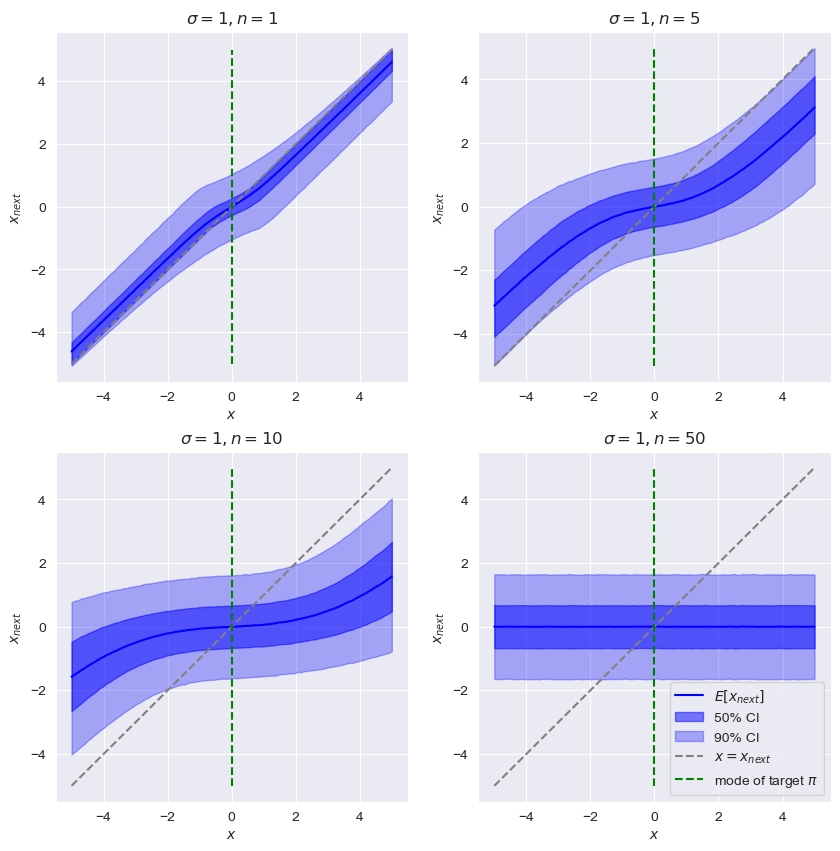

In [43]:
x = jnp.linspace(-5, 5, 100)
fig, axs = plt.subplots(2,2, sharex=False, sharey=False, figsize=(10,10))

for n, ax1 in zip([1, 5, 10, 50], axs.flatten()):
    Px = kernel_rwm_normal.sample_Pnx(rng_key, x, rwm_s1, n=n, n_samples=int(1e5))
    
    Px_mean = Px.mean(axis=1) 
    P1x_low = jnp.quantile(Px, 0.25, axis=1)
    P1x_up = jnp.quantile(Px, 0.75, axis=1)
    P1x_lower = jnp.quantile(Px, 0.05, axis=1)
    P1x_upper = jnp.quantile(Px, 0.95, axis=1)
    
    ax1.set_title(rf"$\sigma=1, n={n}$")
    
    ax1.plot(x, Px_mean, color='blue', label="$E[x_{next}]$")
    ax1.fill_between(x, P1x_low, P1x_up, alpha=0.5, color="blue", label="50% CI")
    ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
    
    ax1.plot(x, x, '--', color="gray", label=r"$x=x_{next}$")
    ax1.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
    
    ax1.set_ylabel("$x_{next}$")
    ax1.set_xlabel("$x$")
    
axs[1,1].legend(loc="lower right")
# plt.tight_layout()
    
fig.savefig(svg_dir + f"rwm-normal-x-step-s1.svg", format="svg") 

In [14]:
%%time 

N = 10000
n = 5

P1x = kernel_normal.sample_Pnx(rng_key, X, s1, n, N).squeeze()
# P2x = sample_Pnx(rng_key, kernel, X, s2, n, N).squeeze()

NameError: name 'X' is not defined

In [60]:
x = X.squeeze()
Px = P1x - X

dP1x_mean = dP1x.mean(axis=1) 
dP1x_acc_mean = dP1x.mean(axis=1, where=(dP1x != 0.0)) 
P1x_lower = jnp.quantile(dP1x, 0.05, axis=1)
P1x_upper = jnp.quantile(dP1x, 0.95, axis=1)

# dP2x = P2x - X
# dP2x_mean = dP2x.mean(axis=1)
# dP2x_acc_mean = dP1x.mean(axis=1, where=(dP2x != 0.0))
# P2x_lower = jnp.quantile(dP2x, 0.05, axis=1)
# P2x_upper = jnp.quantile(dP2x, 0.95, axis=1)
# P2x_lower, P2x_upper = hpdi(dP2x , prob=0.99, axis=1).reshape(2, -1)

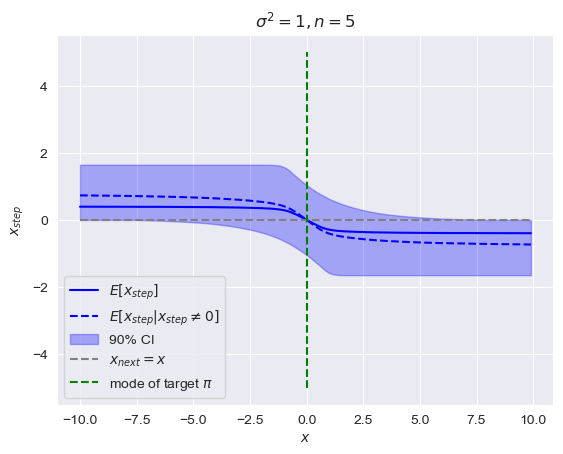

In [72]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(11,5))
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\sigma^2=1, n=5$")
ax1.plot(x, dP1x_mean, color='blue', label="$E[x_{step}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2^5$")
ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2^5$")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, lr_rate=0.3, color="orange", label="90% CI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
# ax2.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
ax1.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
# ax2.vlines(0, -10, 10, linestyles='--', color="green", label=r"mode of target $\pi$")
ax1.set_ylabel("$x_{step}$")
ax1.set_xlabel("$x$")
# ax2.set_xlabel("$x$")
ax1.legend(loc="lower left")
# ax2.legend(loc="lower left")
# plt.savefig(svg_dir + "univariate-x-step-cov1-n5.svg", format="svg")

## 1.3. Invariance Property

In [20]:
%%time

k1, k2, ks = random.split(random.PRNGKey(0), 3)
dist_samples = normal_dist.sample(ks, sample_shape=(1000000,))

P1pi = kernel_rwm_normal.sample_Pnx(k1, dist_samples, get_arwm_adapt_state(scale=1.0), n_samples=1).flatten()
P2pi = kernel_sss_normal.sample_Pnx(k1, dist_samples, sss_s1, n_samples=1).flatten()

# P2pi = sample_Px(k2, kernel, dist_samples, s2, n_samples=1000).flatten()

CPU times: user 2.08 s, sys: 73.6 ms, total: 2.15 s
Wall time: 871 ms


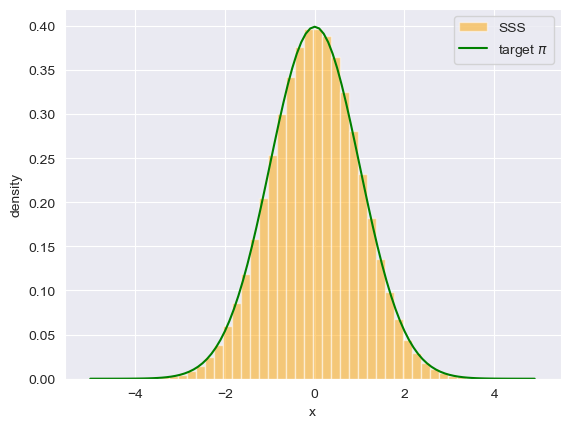

In [22]:
# plt.hist(P1pi, bins=50, density=True, lr_rate=0.5, color="blue", label=r"RWM")
plt.hist(P2pi, bins=50, density=True, alpha=0.5, color="orange", label=r"SSS")
# plt.hist(dist_samples, bins=50, density=True, lr_rate=0.5, color="green", label=r"samples from $\pi$")

# plt.hist(P2pi, bins=50, density=True, lr_rate=0.5, label=r"samples from $\pi P_2$")
x = jnp.arange(-5, 5, 0.1)
plt.plot(x, jnp.exp(normal_dist.log_prob(x)), color="green", label=r"target $\pi$")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()
# plt.savefig(svg_dir + "asss-univariate-invariance.svg", format="svg")
# plt.hist(dist_samples, bins=50, density=True, lr_rate=0.5, color="green", label=r"samples from $\pi$")

# plt.savefig(svg_dir + "asss-univariate-invariance.svg", format="svg")

## 1.4. Contraction Property

In [9]:
def get_taus_n(rng_key, kernel, X, adapt_state, n: int = 1, n_samples: int = 10000, eps=5e-2):
    # @jit
    def get_taus_n_x(x):
        X_eps = jnp.stack([x-eps, x+eps], axis=0)  # (2, dim)
        Pnx_l, Pnx_r = kernel.sample_Pnx(rng_key, X_eps, adapt_state, n, n_samples).squeeze()
        W_dist = wasserstein_1d(Pnx_l, Pnx_r)
        return W_dist / (2*eps)
    
    taus_n = jax.lax.map(get_taus_n_x, X, batch_size=10)

    return taus_n

In [10]:
def get_taus_n_sss(rng_key, kernel, X, adapt_state, n: int = 1, n_samples: int = 10000, eps=1e-1):
    loc, scale = adapt_state
    @jit
    def get_taus_n_x(x):
        phi = 2*jnp.arctan( (x - loc) / scale )
        phis = jnp.array([phi - eps, phi + eps])
        X_eps = (jnp.tan(phis / 2) * scale + loc).reshape(2, -1)  # (2, dim)
        Pnx_l, Pnx_r = kernel.sample_Pnx(rng_key, X_eps, adapt_state, n, n_samples).squeeze()
        W_dist = wasserstein_1d(Pnx_l, Pnx_r)
        dx = jnp.diff(X_eps, axis=0).squeeze()
        return W_dist / dx
    
    taus_n = jax.lax.map(get_taus_n_x, X, batch_size=10)

    return taus_n

In [14]:
rng_key = random.PRNGKey(0)

# x = jnp.linspace(-5, 5, 50)
phis = jnp.linspace(-jnp.arctan(5), jnp.arctan(5), 100)
x = jnp.tan(phis)
X = x.reshape(-1, 1)

N = int(2e6)
eps = 1e-1

In [12]:
taus1_ = get_taus_n_sss(rng_key, kernel_sss_normal, X, sss_s1, n=1, n_samples=N, eps=eps)
taus2_ = get_taus_n_sss(rng_key, kernel_sss_normal, X, sss_s1, n=2, n_samples=N, eps=eps)

print(taus2_.max())


0.022612354


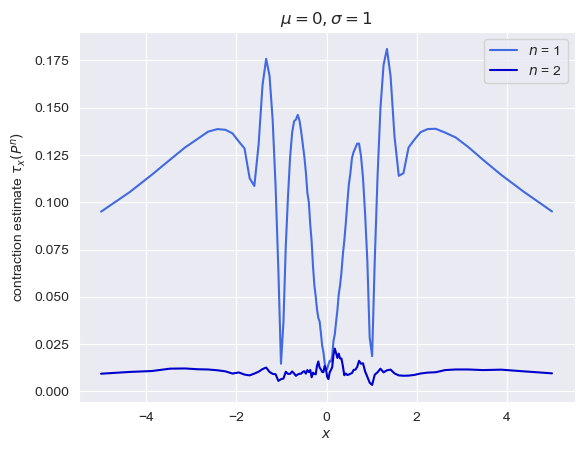

In [15]:
plt.title(r"$\mu=0, \sigma = 1$")
plt.plot(x, taus1_, color="royalblue", label=r"$n$ = 1")
plt.plot(x, taus2_, color="mediumblue", label=r"$n$ = 2")
# plt.plot(x, taus10, color="midnightblue", label=r"$n$ = 10")
# plt.plot(x, taus10, color="darkblue", label=r"$n$ = 10")
# plt.plot(x, taus25, color="midnightblue", label=r"$n$ = 25")
# plt.semilogy()
plt.xlabel("$x$")
plt.ylabel(r"contraction estimate $\tau_x(P^n)$")
plt.legend(loc="upper right")
# plt.savefig(svg_dir + "sss-normal-x-contraction-m0.svg", format="svg")

In [17]:

# taus1 = get_taus_n(rng_key, kernel_rwm_normal, X, rwm_s1, n=1, n_samples=N, eps=eps)
# taus5 = get_taus_n(rng_key, kernel_rwm_normal, X, rwm_s1, n=5, n_samples=N, eps=eps)
# taus10 = get_taus_n(rng_key, kernel_rwm_normal, X, rwm_s1, n=10, n_samples=N, eps=eps)

taus1 = get_taus_n_sss(rng_key, kernel_sss_normal, X, sss_s4, n=1, n_samples=N, eps=eps)
taus2 = get_taus_n_sss(rng_key, kernel_sss_normal, X, sss_s4, n=2, n_samples=N, eps=eps)

# x_vals2, taus2 = get_taus_n(rng_key, kernel, X, s1, n=2, n_samples=N)
# x_vals5, taus5 = get_taus_n(rng_key, kernel, X, s1, n=5, n_samples=N)
# taus10 = get_taus_n(rng_key, kernel_sss_normal, X, s1, n=10, n_samples=N)
# taus25 = get_taus_n(rng_key, kernel_sss_normal, X, s1, n=25, n_samples=N)

print(taus2.max())

0.36068642


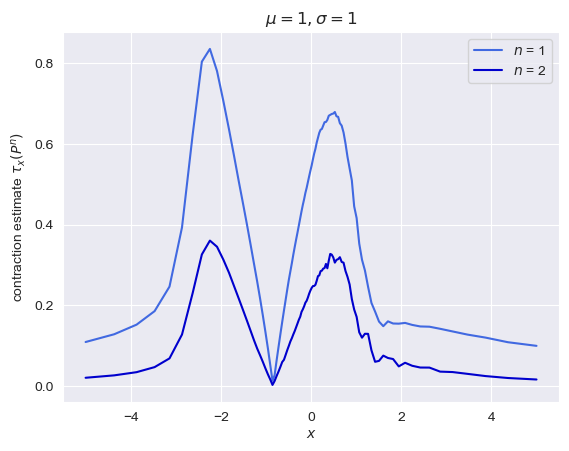

In [18]:
plt.title(r"$\mu=1, \sigma = 1$")
plt.plot(x, taus1, color="royalblue", label=r"$n$ = 1")
plt.plot(x, taus2, color="mediumblue", label=r"$n$ = 2")
# plt.plot(x, taus10, color="midnightblue", label=r"$n$ = 10")
# plt.plot(x, taus10, color="darkblue", label=r"$n$ = 10")
# plt.plot(x, taus25, color="midnightblue", label=r"$n$ = 25")
# plt.semilogy()
plt.xlabel("$x$")
plt.ylabel(r"contraction estimate $\tau_x(P^n)$")
plt.legend(loc="upper right")
plt.savefig(svg_dir + "sss-normal-x-contraction-m1.svg", format="svg")

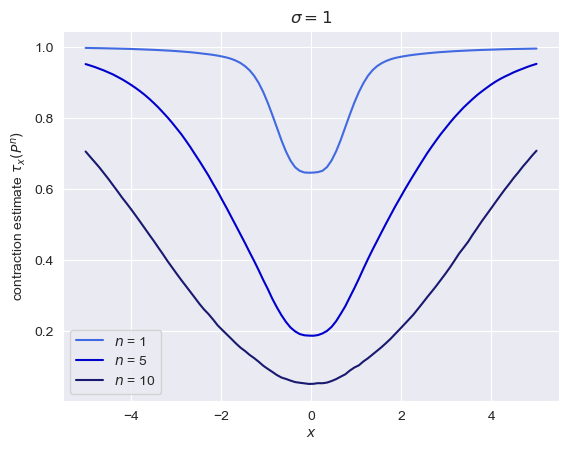

In [22]:
# plt.title(r"$\sigma = 1$")
# plt.plot(x, taus1, color="royalblue", label=r"$n$ = 1")
# plt.plot(x, taus5, color="mediumblue", label=r"$n$ = 5")
# plt.plot(x, taus10, color="midnightblue", label=r"$n$ = 10")
# # plt.plot(x, taus10, color="darkblue", label=r"$n$ = 10")
# # plt.plot(x, taus25, color="midnightblue", label=r"$n$ = 25")
# # plt.semilogy()
# plt.xlabel("$x$")
# plt.ylabel(r"contraction estimate $\tau_x(P^n)$")
# plt.legend(loc="lower left")
# plt.savefig(svg_dir + "rwm-normal-x-contraction.svg", format="svg")

In [91]:
%%time

steps = [0, 5, 10, 100]
fxs = []
Pfxs = []

n = 1
rng_key = random.PRNGKey(0)

x = jnp.linspace(-5, 5, 100)
X = x.reshape(-1, 1)

normal_samples = normal_dist.sample(rng_key, sample_shape=(int(1e5), 1))

sample_fn = lambda rng_key, x, n_samples: kernel_rwm_normal.sample_Pnx(rng_key, x, rwm_s1, n, n_samples)

for i in steps:
    tau, model, params = compute_wasserstein_contraction(sample_fn, rng_key, X, n_train_batches=50, n_eval_batches=1, max_steps=i)
    
    # f_mean = model.apply(params, normal_samples).mean()
    
    f = lambda x: model.apply(params, x)
    
    fxs.append(f(X))
    Pfxs.append(f(sample_fn(rng_key, X, n_samples=int(1e5))).mean(axis=-1))

Train finished in 0 steps. Last gradient norm: 1.0.
Train finished in 5 steps. Last gradient norm: 0.019985387101769447.
Train finished in 10 steps. Last gradient norm: 0.003940194379538298.
Train finished in 100 steps. Last gradient norm: 0.00041332526598125696.
CPU times: user 7min 36s, sys: 11.8 s, total: 7min 48s
Wall time: 2min 1s


Text(0.5, 0, 'x')

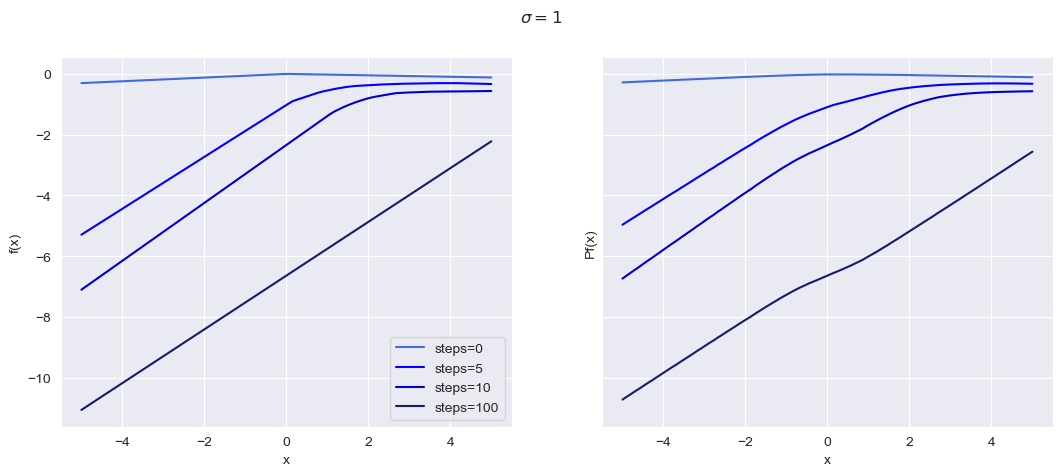

In [94]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True)
fig.suptitle(r"$\sigma=1$")

colors = ["royalblue", "blue", "mediumblue", "midnightblue"]

for step, fx, Pfx, color in zip(steps, fxs, Pfxs, colors):
    ax1.plot(x, fx, label=f"steps={step}", color=color)
    ax2.plot(x, Pfx, label=f"steps={step}", color=color)

ax1.legend(loc="lower right")

ax1.set_ylabel("f(x)")
ax2.set_ylabel("Pf(x)")
ax1.set_xlabel("x")
ax2.set_xlabel("x")

# fig.savefig(svg_dir + "rwm-normal-contraction-dual.svg", format="svg")

In [67]:
def Pf(x, rng_key=random.PRNGKey(0), n_samples=1000, n_batches=10):
    rng_keys = random.split(rng_key, n_batches)
    
    def Pf_batch(r_key):
        samples = sample_fn(r_key, x, n_samples)
        return f(samples).mean()
    
    return vmap(Pf_batch)(rng_keys).mean(axis=0)         

In [13]:
rng_key = random.PRNGKey(0)

# x = jnp.linspace(-5, 5, 100)
phis = jnp.linspace(-jnp.arctan(2.5), jnp.arctan(2.5), 50)
x = jnp.tan(phis)
X = x.reshape(-1, 1)

N = int(5e5)
eps = 1e-1

def get_max_taus(n_list, adapt_state):
       
    # rng_keys = random.split(rng_key, tau_samples)
    
    def max_tau_fn(n):
        # sample_fn = lambda rng_key: kernel_sss_mixture.sample_Pnx(rng_key, X, adapt_state, n=n, n_samples=1000).mean(axis=1)
        # Pnx = jax.lax.map(sample_fn, rng_keys, batch_size=100).mean(axis=0).squeeze()
        # taus_n = jnp.abs((Pnx[2:] - Pnx[:-2])/(x[2:] - x[:-2]))
        taus_n = get_taus_n_sss(rng_key, kernel_sss_normal, X, adapt_state, n=n, n_samples=N, eps=eps)
        
        return taus_n.max()
    
    return [max_tau_fn(n) for n in n_list]

In [14]:
%%time
x = get_taus_n_sss(rng_key, kernel_sss_normal, X, sss_s1, n=1, n_samples=N, eps=eps)
print(x)

[0.13749427 0.13784078 0.13309874 0.12080273 0.12760013 0.17321618
 0.16587035 0.11561218 0.04040072 0.04384528 0.09744439 0.12681857
 0.14603475 0.15111035 0.14886083 0.14444587 0.12653562 0.10962022
 0.10412868 0.07945453 0.05619029 0.04250671 0.0353291  0.0255759
 0.02115004 0.02858813 0.02533795 0.02444958 0.02693902 0.03665483
 0.04882394 0.06087109 0.07091778 0.08357223 0.1012999  0.11778017
 0.12223762 0.14037713 0.13296156 0.10337605 0.05073283 0.03696393
 0.11621223 0.16249697 0.16987962 0.1222439  0.1161537  0.13087057
 0.13662301 0.13695103]
CPU times: user 2min 30s, sys: 1.22 s, total: 2min 31s
Wall time: 43.2 s


In [15]:
%%time
n_list = [1, 2, 3, 4, 5]

max_taus_s1 = get_max_taus(n_list, sss_s1)
max_taus_s2 = get_max_taus(n_list, sss_s2)
max_taus_s3 = get_max_taus(n_list, sss_s3)

max_taus_s4 = get_max_taus(n_list, sss_s4)
max_taus_s5 = get_max_taus(n_list, sss_s5)
max_taus_s6 = get_max_taus(n_list, sss_s6)

print(max_taus_s6[-1])

0.008646628
CPU times: user 4h 21min 40s, sys: 1min 29s, total: 4h 23min 9s
Wall time: 1h 6min 58s


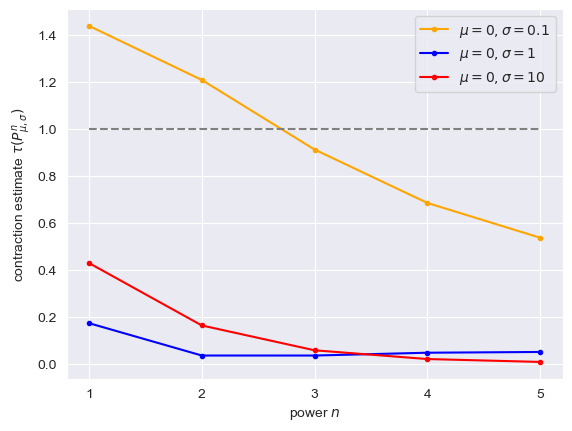

In [17]:
fig, ax1 = plt.subplots(1, 1)
# plt.title(r"$\sigma^2=1, n=5$")

ax1.plot(n_list, max_taus_s2, ".-", color='orange', label=r"$\mu=0, \sigma = 0.1$")
ax1.plot(n_list, max_taus_s1, ".-", color='blue', label=r"$\mu=0, \sigma = 1$")
ax1.plot(n_list, max_taus_s3, ".-", color='red', label=r"$\mu=0, \sigma = 10$")

ax1.hlines(1, n_list[0], n_list[-1], linestyles='--', color="gray")

ax1.set_ylabel(r"contraction estimate $ \tau(P_{\mu, \sigma}^n)$")

ax1.set_xticks(n_list)
# ax1.set_yticks([0.1, 0.5, 1])
# ax1.semilogy()

ax1.set_xlabel("power $n$")
ax1.legend(loc="upper right")
plt.savefig(svg_dir + "sss-normal-contraction-decrease-m0.svg", format="svg")

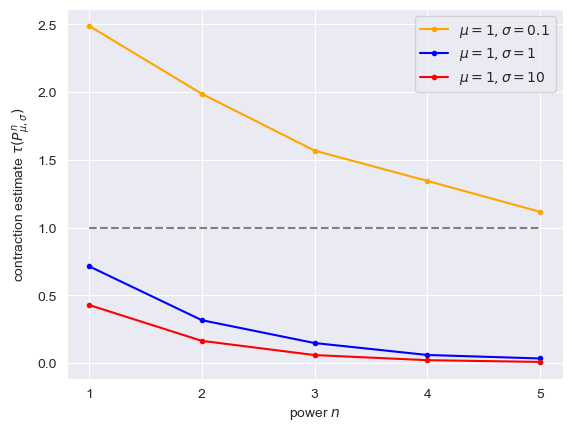

In [18]:
fig, ax1 = plt.subplots(1, 1)
# plt.title(r"$\sigma^2=1, n=5$")

ax1.plot(n_list, max_taus_s5, ".-", color='orange', label=r"$\mu=1, \sigma = 0.1$")
ax1.plot(n_list, max_taus_s4, ".-", color='blue', label=r"$\mu=1, \sigma = 1$")
ax1.plot(n_list, max_taus_s6, ".-", color='red', label=r"$\mu=1, \sigma = 10$")

ax1.hlines(1, n_list[0], n_list[-1], linestyles='--', color="gray")

ax1.set_ylabel(r"contraction estimate $ \tau(P_{\mu, \sigma}^n)$")

ax1.set_xticks(n_list)
# ax1.set_yticks([0.1, 0.5, 1])
# ax1.semilogy()

ax1.set_xlabel("power $n$")
ax1.legend(loc="upper right")
plt.savefig(svg_dir + "sss-normal-contraction-decrease-m1.svg", format="svg")

In [12]:
X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

N = 10000

rng_key = random.PRNGKey(0)

## 1.5 Kernel distance

In [ ]:
# compute_kernel_distance()

In [9]:
rng_key = random.PRNGKey(0)

mcmc = infer.MCMC(kernel_nuts_normal, num_warmup=0, num_samples=10000)
mcmc.run(rng_key, extra_fields=("adapt_state",), init_params=jnp.array([0.0]))

TypeError: Gradient only defined for scalar-output functions. Output had shape: (1,).

In [46]:
adapt_states = mcmc.get_extra_fields()["adapt_state"]
# mean, cov, lam = adapt_states

In [46]:
proposal_cov = jnp.expand_dims(jnp.exp(lam), [1,2]) * cov

In [48]:
from ARWMH import state_dist

In [53]:
idx1 = 100 
s1 = ARWMHAdaptState(mean[idx1], cov[idx1], lam[idx1])

In [54]:
s1

AMHAdaptState(mean=Array([0.03975414], dtype=float32), covariance=Array([[1.2438252]], dtype=float32), log_step_size=Array(1.4834536, dtype=float32))

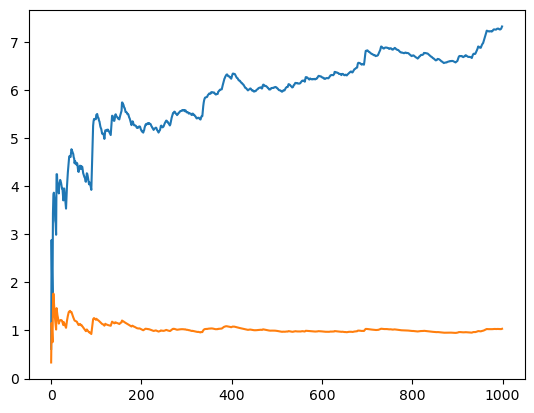

In [47]:
plt.plot(proposal_cov.squeeze())
plt.plot(cov.squeeze())

In [10]:

sample_P = lambda rng_key, x, n_samples: sample_Pnx(rng_key, kernel, x, s1, 1, n_samples)
sample_Q = lambda rng_key, x, n_samples: sample_Pnx(rng_key, kernel, x, s2, 1, n_samples)

rng_key = random.PRNGKey(0)
X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)

In [11]:
rho, f = compute_kernel_distance(sample_P, sample_Q, rng_key, X, n_samples=5000, steps=200)

Step 0, Loss: -0.6671554446220398, Grad norm: 0.0005533649818971753
Step 10, Loss: -0.7025560736656189, Grad norm: 0.006827943027019501
Step 20, Loss: -0.7053455710411072, Grad norm: 0.006397875491529703
Step 30, Loss: -0.7057971358299255, Grad norm: 0.006377199664711952
Step 40, Loss: -0.7070958614349365, Grad norm: 0.007317858748137951
Step 50, Loss: -0.7041546702384949, Grad norm: 0.005662539973855019
Step 60, Loss: -0.7071062922477722, Grad norm: 0.006836296524852514
Step 70, Loss: -0.7051123380661011, Grad norm: 0.00584377720952034
Step 80, Loss: -0.7048067450523376, Grad norm: 0.00602379348129034
Step 90, Loss: -0.7059532999992371, Grad norm: 0.006388838402926922
Step 100, Loss: -0.7064651846885681, Grad norm: 0.006562430877238512
Step 110, Loss: -0.7040368914604187, Grad norm: 0.0057345847599208355
Step 120, Loss: -0.705633282661438, Grad norm: 0.006236946675926447
Step 130, Loss: -0.7060680389404297, Grad norm: 0.0062217810191214085
Step 140, Loss: -0.7073402404785156, Grad nor

In [12]:
rho

Array(0.19459969, dtype=float32)

In [18]:
X = jnp.arange(-10, 10, 0.01).reshape(-1, 1)
x = X.squeeze()

func = lambda x: f(x.reshape(-1, 1))
# fx = vmap(func)(x)

Px = sample_P(rng_key, X, n_samples=10000)
Qx = sample_Q(rng_key, X, n_samples=10000)

Pfx = vmap(func)(Px).mean(axis=1)
Qfx = vmap(func)(Qx).mean(axis=1)

diff = Pfx - Qfx

# 2. Gaussian Mixture

In [9]:
mixing_dist = dist.Categorical(probs=jnp.array([1/2, 1/2]))
component_dist = dist.Normal(loc=jnp.array([-1, 1]), scale=jnp.array([.1, .1]))
mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

potential_fn = lambda x: -1 *mixture.log_prob(x)

In [10]:
kernel_rwm_mixture = ARWMH(potential_fn=potential_fn)
kernel_sss_mixture = ASSS(potential_fn=potential_fn)

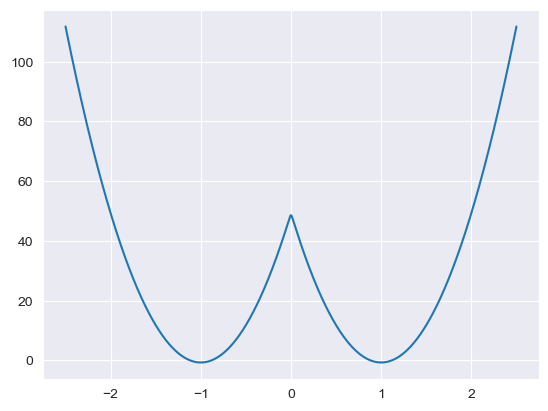

In [11]:
x = jnp.linspace(-2.5, 2.5, 1000)
plt.plot(x, -mixture.log_prob(x))

## 1.2. Sampling from $P(x, \cdot)$

In [117]:
rng_key = random.PRNGKey(1)

x = jnp.arange(-5, 5, 0.1)
y = jnp.arange(-2.5, 2.5, 0.1)
x1, x2 = jnp.meshgrid(x, y)
X = jnp.stack([x1, x2], axis=-1).reshape(-1, 2)

In [118]:
%%time 

N = int(1e4)

# P1x = kernel_sss_mixture.sample_Pnx(rng_key, X, s4, n=5, n_samples=N).squeeze()
P1x = kernel_rwm_mixture.sample_Pnx(rng_key, X, get_arwm_adapt_state(1.0), n=1, n_samples=N).squeeze()


print(P1x.mean())

-0.03683384
CPU times: user 13.1 s, sys: 4.92 s, total: 18 s
Wall time: 5.54 s


In [120]:
P1x.mean(axis=1)

Array([[-4.4413767, -1.9413763],
       [-4.325502 , -1.9255021],
       [-4.2425704, -1.9425697],
       ...,
       [ 4.1334395,  1.8334442],
       [ 4.2388334,  1.8388386],
       [ 4.3452196,  1.845224 ]], dtype=float32)

In [129]:
P1x_mean = P1x.mean(axis=1) 
P1x_low = jnp.quantile(P1x, 0.25, axis=1)
P1x_up = jnp.quantile(P1x, 0.75, axis=1)
P1x_lower = jnp.quantile(P1x, 0.05, axis=1)
P1x_upper = jnp.quantile(P1x, 0.95, axis=1)

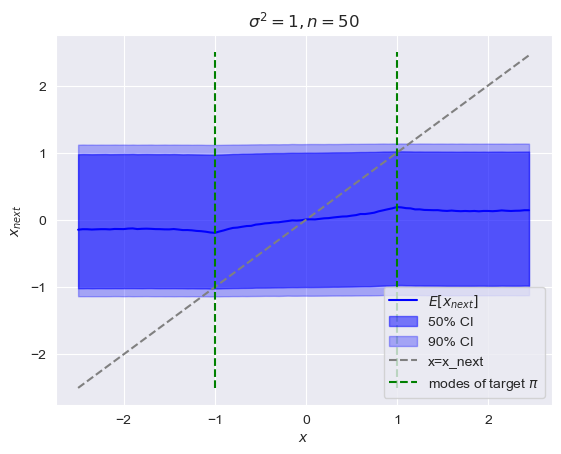

In [131]:
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\sigma^2=1, n=50$")

ax1.plot(x, P1x_mean, color='blue', label="$E[x_{next}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2$")
# ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2$")
ax1.fill_between(x, P1x_low, P1x_up, alpha=0.5, color="blue", label="50% CI")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, lr_rate=0.3, color="orange", label="90% CI")
ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
# ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = 0$")
ax1.vlines([-1, 1], -2.5, 2.5, linestyles='--', color="green", label=r"modes of target $\pi$")
ax1.set_ylabel("$x_{next}$")
ax1.set_xlabel("$x$")
ax1.legend(loc="lower right")

plt.savefig(svg_dir + "rwm-mixture-x-step-cov1-n50.svg", format="svg")

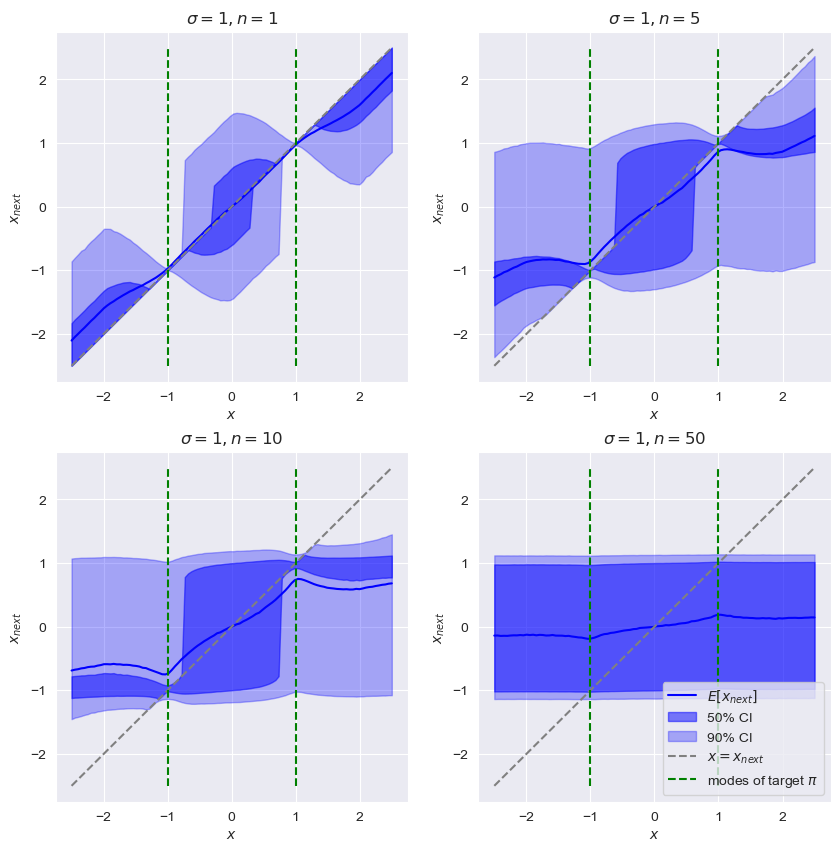

In [45]:
x = jnp.linspace(-2.5, 2.5, 100)
fig, axs = plt.subplots(2,2, sharex=False, sharey=False, figsize=(10,10))

for n, ax1 in zip([1, 5, 10, 50], axs.flatten()):
    Px = kernel_rwm_mixture.sample_Pnx(rng_key, x, rwm_s1, n=n, n_samples=int(1e5))
    
    Px_mean = Px.mean(axis=1) 
    P1x_low = jnp.quantile(Px, 0.25, axis=1)
    P1x_up = jnp.quantile(Px, 0.75, axis=1)
    P1x_lower = jnp.quantile(Px, 0.05, axis=1)
    P1x_upper = jnp.quantile(Px, 0.95, axis=1)
    
    ax1.set_title(rf"$\sigma=1, n={n}$")
    
    ax1.plot(x, Px_mean, color='blue', label="$E[x_{next}]$")
    ax1.fill_between(x, P1x_low, P1x_up, alpha=0.5, color="blue", label="50% CI")
    ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
    
    ax1.plot(x, x, '--', color="gray", label=r"$x=x_{next}$")
    ax1.vlines([-1, 1], -2.5, 2.5, linestyles='--', color="green", label=r"modes of target $\pi$")
    
    ax1.set_ylabel("$x_{next}$")
    ax1.set_xlabel("$x$")
    
axs[1,1].legend(loc="lower right")
# plt.tight_layout()
    
fig.savefig(svg_dir + f"rwm-mixture-x-step-s1.svg", format="svg")

In [112]:
x = X.squeeze()
dP1x = P1x - X

dP1x_mean = dP1x.mean(axis=1) 
dP1x_acc_mean = dP1x.mean(axis=1, where=(dP1x != 0.0)) 
P1x_lower = jnp.quantile(dP1x, 0.05, axis=1)
P1x_upper = jnp.quantile(dP1x, 0.95, axis=1)

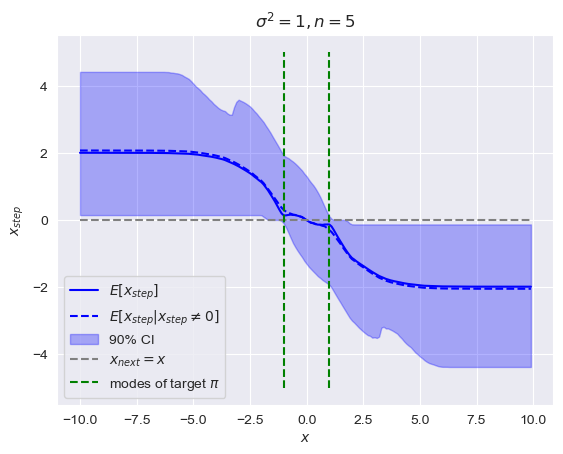

In [113]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(11,5))
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\sigma^2=1, n=5$")

ax1.plot(x, dP1x_mean, color='blue', label="$E[x_{step}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2$")
ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2$")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, lr_rate=0.3, color="orange", label="90% CI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
# ax2.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
ax1.vlines([-1, 1], -5, 5, linestyles='--', color="green", label=r"modes of target $\pi$")
# ax2.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
ax1.set_ylabel("$x_{step}$")
ax1.set_xlabel("$x$")
# ax2.set_xlabel("$x$")
ax1.legend(loc="lower left")
# ax2.legend(loc="lower left")

# plt.savefig(svg_dir + "mixture-x-step-cov1-n5.svg", format="svg")

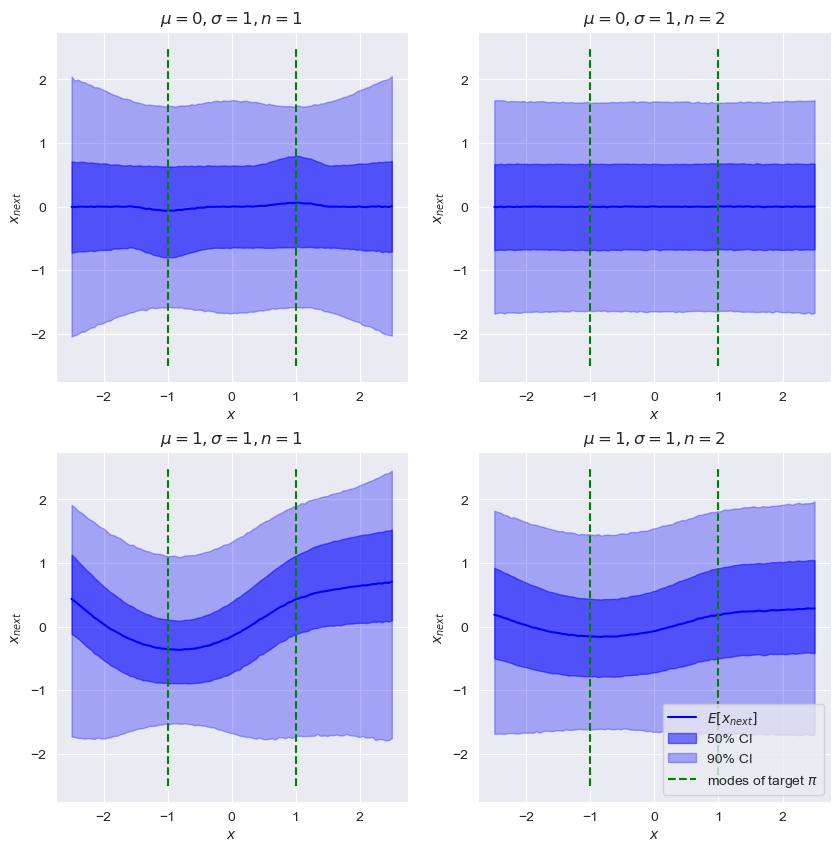

In [46]:
x = jnp.linspace(-2.5, 2.5, 100)
fig, axs = plt.subplots(2,2, sharex=False, sharey=False, figsize=(10,10))

for loc, _axs in zip([0, 1], axs):
    if loc == 0:
        a_s = sss_s1
    else:
        a_s = sss_s4
    
    for n, ax1 in zip([1, 2], _axs):
        Px = kernel_sss_normal.sample_Pnx(rng_key, x, a_s, n=n, n_samples=int(1e5))
        
        Px_mean = Px.mean(axis=1) 
        P1x_low = jnp.quantile(Px, 0.25, axis=1)
        P1x_up = jnp.quantile(Px, 0.75, axis=1)
        P1x_lower = jnp.quantile(Px, 0.05, axis=1)
        P1x_upper = jnp.quantile(Px, 0.95, axis=1)
        
        ax1.set_title(rf"$\mu={loc}, \sigma=1, n={n}$")
        
        ax1.plot(x, Px_mean, color='blue', label="$E[x_{next}]$")
        ax1.fill_between(x, P1x_low, P1x_up, alpha=0.5, color="blue", label="50% CI")
        ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
        
        # ax1.plot(x, x, '--', color="gray", label=r"$x=x_{next}$")
        ax1.vlines([-1, 1], -2.5, 2.5, linestyles='--', color="green", label=r"modes of target $\pi$")
        
        ax1.set_ylabel("$x_{next}$")
        ax1.set_xlabel("$x$")
        
    # fig.savefig(svg_dir + f"sss-normal-x-step-m{loc}-s1-n{n}.svg", format="svg")
    
axs[1,1].legend(loc="lower right") # bbox_to_anchor=(0.15, 0.9)
# plt.tight_layout()
    
fig.savefig(svg_dir + f"sss-mixture-x-step-m01-s1.svg", format="svg")

In [160]:
N = 100000
x = jnp.linspace(-2.5, 2.5, 100)

P1x = kernel_rwm_mixture.sample_Pnx(rng_key, x, rwm_s1, n=1, n_samples=N)
P2x = kernel_rwm_mixture.sample_Pnx(rng_key, x, rwm_s2, n=1, n_samples=N)
P3x = kernel_rwm_mixture.sample_Pnx(rng_key, x, rwm_s3, n=1, n_samples=N)
# 
# P1x = kernel_sss_mixture.sample_Pnx(rng_key, x, sss_s1, n=1, n_samples=N)
# P2x = kernel_sss_mixture.sample_Pnx(rng_key, x, sss_s2, n=1, n_samples=N)
# P3x = kernel_sss_mixture.sample_Pnx(rng_key, x, sss_s3, n=1, n_samples=N)

In [161]:
mixture_samples = mixture.sample(rng_key, sample_shape=(N,))
@jit
def ecc_mixture(x):
    return jnp.abs(mixture_samples[None] - x[:, None]).mean(axis=1)

def Wx_mixture(Px_samples):
    return wasserstein_1d(mixture_samples, Px_samples)

Ex = ecc_mixture(x)

WP1x = vmap(Wx_mixture)(P1x)
WP2x = vmap(Wx_mixture)(P2x)
WP3x = vmap(Wx_mixture)(P3x)

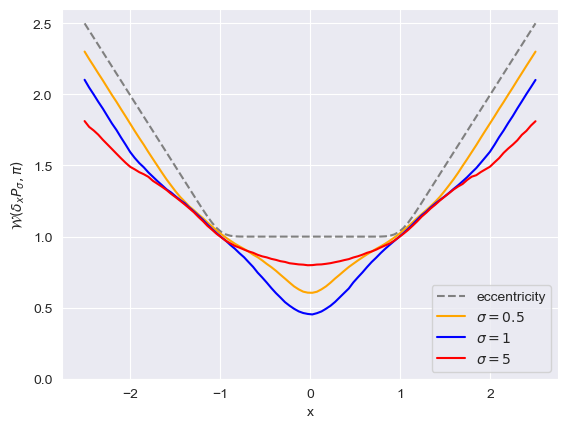

In [164]:
fig, ax = plt.subplots()
# ax.set_title(r"$\sigma^2=1, n=1$")

ax.plot(x, Ex, "--", label="eccentricity", color="gray")
ax.plot(x, WP2x, label=r"$\sigma = 0.5$", color="orange")
ax.plot(x, WP1x, label=r"$\sigma = 1$", color="blue")
ax.plot(x, WP3x, label=r"$\sigma = 5$", color="red")

# ax.plot(x, EPx_mean, color="blue", label="mean")
# 
# ax.fill_between(x, EPx_low, EPx_up, lr_rate=0.5, color="blue", label="50% CI")
# ax.fill_between(x, EPx_lower, EPx_upper, lr_rate=0.3, color="blue", label="90% CI")

# ax.plot([Ex.min(), Ex.max()], [Ex.min(), Ex.max()], '--', color="gray", label="y=x")

ax.legend(loc="lower right")

ax.set_xlabel("x")
ax.set_ylabel(r"$\mathcal{W}(\delta_x P_{\sigma}, \pi)$")
ax.set_ylim(0, 2.6)


# fig.savefig(svg_dir + "rwm-mixture-x-wasserstein.svg", format="svg")

## 1.3. Invariance Property

In [17]:
%%time

k1, k2, ks = random.split(random.PRNGKey(0), 3)
dist_samples = mixture.sample(ks, sample_shape=(100000,1))

P1pi = kernel_sss_mixture.sample_Pnx(k1, dist_samples, s1, n_samples=1).flatten()
# P2pi = sample_Px(k2, kernel, dist_samples, s2, n_samples=1).flatten()

CPU times: user 1.09 s, sys: 48 ms, total: 1.14 s
Wall time: 573 ms


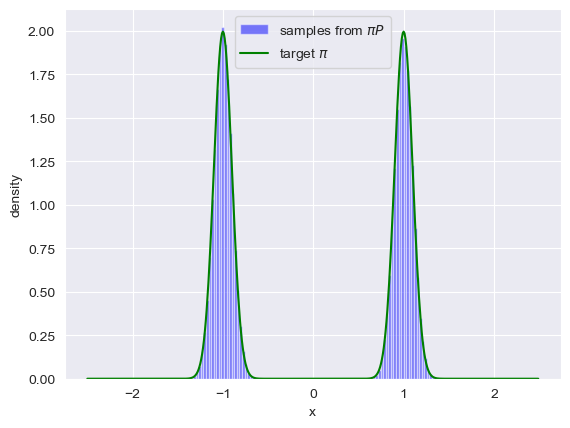

In [21]:
x = jnp.arange(-2.5, 2.5, 0.01)

plt.hist(P1pi, bins=100, density=True, alpha=0.5, color="blue", label=r"samples from $\pi P$")
# plt.hist(dist_samples, bins=100, density=True, lr_rate=0.5, color="green", label=r"samples from $\pi$")

# plt.hist(P2pi, bins=50, density=True, lr_rate=0.5, label=r"samples from $\pi P_2$")
plt.plot(x, jnp.exp(mixture.log_prob(x)), color="green", label=r"target $\pi$")
plt.xlabel("x")
plt.ylabel("density")
plt.legend(loc="upper center")
plt.savefig(svg_dir + "asss-mixture-invariance.svg", format="svg")

## 1.4. Contraction Property

In [12]:
def get_taus_n(rng_key, kernel, X, adapt_state, n: int = 1, n_samples: int = 10000, eps=5e-2):
    @jit
    def get_taus_n_x(x):
        X_eps = jnp.stack([x-eps, x+eps], axis=0)  # (2, dim)
        Pnx_l, Pnx_r = kernel.sample_Pnx(rng_key, X_eps, adapt_state, n, n_samples).squeeze()
        W_dist = wasserstein_1d(Pnx_l, Pnx_r)
        return W_dist / (2*eps)
    
    taus_n = jax.lax.map(get_taus_n_x, X, batch_size=10)

    return taus_n

In [13]:
def get_taus_n_sss(rng_key, kernel, X, adapt_state, n: int = 1, n_samples: int = 10000, eps=1e-1):
    loc, scale = adapt_state
    @jit
    def get_taus_n_x(x):
        phi = 2*jnp.arctan( (x - loc) / scale )
        phis = jnp.array([phi - eps, phi + eps])
        X_eps = (jnp.tan(phis / 2) * scale + loc).reshape(2, -1)  # (2, dim)
        Pnx_l, Pnx_r = kernel.sample_Pnx(rng_key, X_eps, adapt_state, n, n_samples).squeeze()
        W_dist = wasserstein_1d(Pnx_l, Pnx_r)
        dx = jnp.diff(X_eps, axis=0).squeeze()
        return W_dist / dx
    
    taus_n = jax.lax.map(get_taus_n_x, X, batch_size=10)

    return taus_n

In [15]:
rng_key = random.PRNGKey(0)

phis = jnp.linspace(-jnp.arctan(2.5), jnp.arctan(2.5), 100)
x = jnp.tan(phis)
# x = jnp.linspace(-2.5, 2.5, 50)

X = x.reshape(-1, 1)

N = int(1e6)
eps = 5e-2
# adapt_state = get_adapt_state(1.0)

In [18]:
adapt_state = ASSSAdaptState(jnp.array([0.]), jnp.array([[1.]]))
n_list = [1, 2, 5]

taus_n = [get_taus_n_sss(rng_key, kernel_sss_mixture, X, adapt_state, n=n, n_samples=N, eps=eps) for n in n_list]

print(taus_n[-1].max())

0.47332293


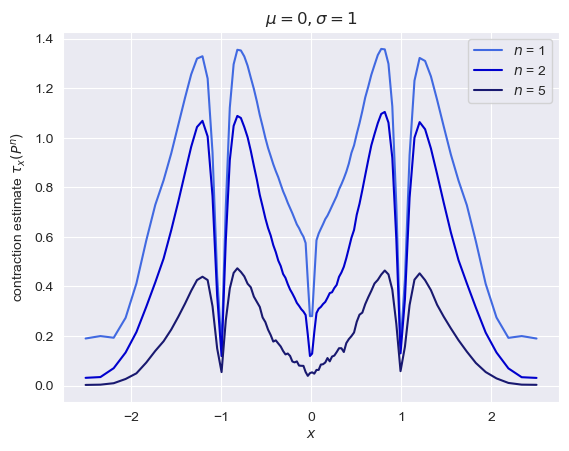

In [19]:
plt.title(r"$\mu = 0, \sigma=1$")

for n, taus, c in zip(n_list, taus_n, ["royalblue", "mediumblue", "midnightblue"]):
    plt.plot(x, taus, color=c, label=rf"$n$ = {n}")
# plt.plot(x, taus1, color="royalblue", label=r"$n$ = 1")
# plt.plot(x, taus2, color="mediumblue", label=r"$n$ = 2")
# plt.plot(x, taus5, color="midnightblue", label=r"$n$ = 5")
# plt.plot(x, taus5, color="mediumblue", label=r"$n$ = 5")
# plt.plot(x, taus10, color="darkblue", label=r"$n$ = 10")
# plt.plot(x, taus25, color="darkblue", label=r"$n$ = 25")
# plt.plot(x, taus5, color="midnightblue", label=r"$n$ = 5")

# plt.semilogy()
plt.xlabel("$x$")
plt.ylabel(r"contraction estimate $\tau_x(P^n)$")
plt.legend(loc="upper right")

plt.savefig(svg_dir + "sss-mixture-x-contraction-m0.svg", format="svg")

In [14]:
adapt_state = ASSSAdaptState(jnp.array([1.]), jnp.array([[1.]]))
n_list = [1, 5, 10]

taus_n_m1 = [get_taus_n_sss(rng_key, kernel_sss_mixture, X, adapt_state, n=n, n_samples=N, eps=eps) for n in n_list]

print(taus_n_m1[-1].max())

1.0112833


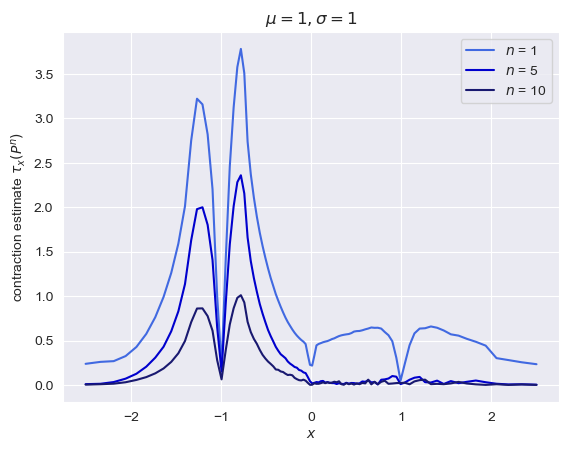

In [15]:
plt.title(r"$\mu = 1, \sigma=1$")
for n, taus, c in zip(n_list, taus_n_m1, ["royalblue", "mediumblue", "midnightblue"]):
    plt.plot(x, taus, color=c, label=rf"$n$ = {n}")

plt.xlabel("$x$")
plt.ylabel(r"contraction estimate $\tau_x(P^n)$")
plt.legend()

plt.savefig(svg_dir + "sss-mixture-x-contraction-m1.svg", format="svg")

In [35]:
%%time

n = 1
rng_key = random.PRNGKey(0)

x = jnp.arange(-2.5, 2.5, 0.05)
X = x.reshape(-1, 1)

sample_fn = lambda rng_key, x, n_samples: kernel_sss_mixture.sample_Pnx(rng_key, x, s1, n, n_samples)
tau, model, params = compute_wasserstein_contraction(sample_fn, rng_key, X, n_train_batches=10, n_eval_batches=100)

print(tau)

Train finished in 100 steps. Last gradient norm: 4.726972946400565e-08.
0.5205028
CPU times: user 35min 43s, sys: 36 s, total: 36min 19s
Wall time: 14min 11s


In [16]:
f= lambda x: model.apply(params, x)

f_mean = f(mixture.sample(rng_key, sample_shape=(100000,1))).mean()

Pf = f(sample_fn(rng_key, X, n_samples=int(1e5))).mean(axis=-1)
Pf -= f_mean

plt.plot(x, Pf)
plt.plot(x[1:-1], (Pf[:-2] - Pf[2:]) / (x[:-2] - x[2:]))

NameError: name 'mixture' is not defined

In [17]:
plt.plot(x, f(X))

NameError: name 'model' is not defined

In [16]:
rng_key = random.PRNGKey(0)

# x = jnp.linspace(-2.5, 2.5, 100)
phis = jnp.linspace(-jnp.arctan(2.5), jnp.arctan(2.5), 50)
x = jnp.tan(phis)
X = x.reshape(-1, 1)

N = int(5e5)
eps = 1e-1

def get_max_taus(n_list, adapt_state, tau_samples=1000):
       
    # rng_keys = random.split(rng_key, tau_samples)
    
    def max_tau_fn(n):
        # sample_fn = lambda rng_key: kernel_sss_mixture.sample_Pnx(rng_key, X, adapt_state, n=n, n_samples=1000).mean(axis=1)
        # Pnx = jax.lax.map(sample_fn, rng_keys, batch_size=100).mean(axis=0).squeeze()
        # taus_n = jnp.abs((Pnx[2:] - Pnx[:-2])/(x[2:] - x[:-2]))
        taus_n = get_taus_n_sss(rng_key, kernel_sss_mixture, X, adapt_state, n=n, n_samples=N, eps=eps)
        
        return taus_n.max()
    
    return [max_tau_fn(n) for n in n_list]

In [17]:
%%time
taus = get_taus_n_sss(rng_key, kernel_sss_mixture, X, sss_s1, n=1, n_samples=N, eps=eps)
print(taus.max())

1.3503939
CPU times: user 3min 59s, sys: 2.13 s, total: 4min 2s
Wall time: 1min 44s


In [18]:
%%time
# n_list = [1, 10, 50, 100, 200]
n_list = [1, 5, 10, 20]

max_taus_s1 = get_max_taus(n_list, sss_s1)
max_taus_s2 = get_max_taus(n_list, sss_s2)
max_taus_s3 = get_max_taus(n_list, sss_s3)

print(max_taus_s3[-1])

0.005598169
CPU times: user 7h 22min 21s, sys: 2min 38s, total: 7h 24min 59s
Wall time: 2h 28min 28s


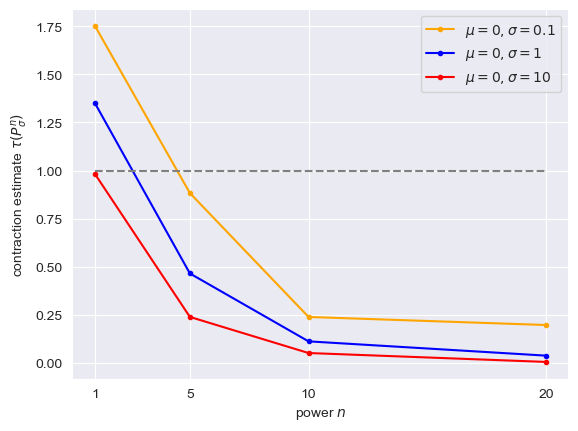

In [19]:
fig, ax1 = plt.subplots(1, 1)
# plt.title(r"$\sigma^2=1, n=5$")

ax1.plot(n_list, max_taus_s2, ".-", color='orange', label=r"$\mu=0, \sigma = 0.1$")
ax1.plot(n_list, max_taus_s1, ".-", color='blue', label=r"$\mu=0, \sigma = 1$")
ax1.plot(n_list, max_taus_s3, ".-", color='red', label=r"$\mu=0, \sigma = 10$")

# ax1.plot(n_list, max_taus_s5, ".-", color='orange', label=r"$\mu=1, \sigma = 0.1$")
# ax1.plot(n_list, max_taus_s4, ".-", color='blue', label=r"$\mu=1, \sigma = 1$")
# ax1.plot(n_list, max_taus_s6, ".-", color='red', label=r"$\mu=1, \sigma = 10$")

ax1.hlines(1, n_list[0], n_list[-1], linestyles='--', color="gray")

ax1.set_ylabel(r"contraction estimate $ \tau(P_{\sigma}^n)$")

ax1.set_xticks(n_list)
# ax1.semilogy()


ax1.set_xlabel("power $n$")
ax1.legend(loc="upper right")
plt.savefig(svg_dir + "sss-mixture-contraction-decrease-m0.svg", format="svg")

In [20]:
%%time
n_list = [1, 5, 10, 20]

max_taus_s4 = get_max_taus(n_list, sss_s4)
max_taus_s5 = get_max_taus(n_list, sss_s5)
max_taus_s6 = get_max_taus(n_list, sss_s6)

print(max_taus_s6[-1])

0.005381542
CPU times: user 7h 48min 1s, sys: 2min 21s, total: 7h 50min 22s
Wall time: 2h 37min 28s


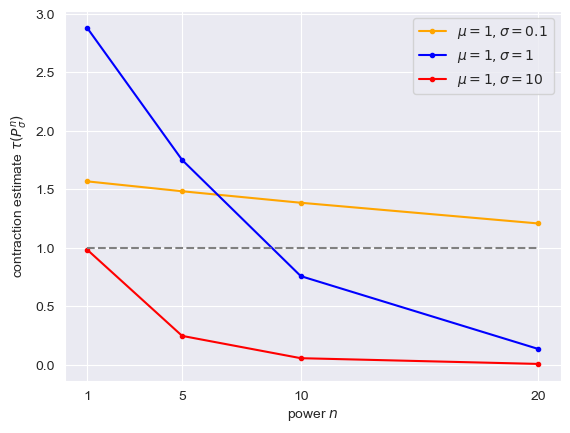

In [21]:
fig, ax1 = plt.subplots(1, 1)
# plt.title(r"$\sigma^2=1, n=5$")

# ax1.plot(n_list, max_taus_s2, ".-", color='orange', label=r"$\sigma = 0.5$")
# ax1.plot(n_list, max_taus_s1, ".-", color='blue', label=r"$\sigma = 1$")
# ax1.plot(n_list, max_taus_s3, ".-", color='red', label=r"$\sigma = 5$")


ax1.plot(n_list, max_taus_s5, ".-", color='orange', label=r"$\mu=1, \sigma = 0.1$")
ax1.plot(n_list, max_taus_s4, ".-", color='blue', label=r"$\mu=1, \sigma = 1$")
ax1.plot(n_list, max_taus_s6, ".-", color='red', label=r"$\mu=1, \sigma = 10$")

ax1.hlines(1, n_list[0], n_list[-1], linestyles='--', color="gray")

ax1.set_ylabel(r"contraction estimate $ \tau(P_{\sigma}^n)$")

ax1.set_xticks(n_list)
# ax1.semilogy()


ax1.set_xlabel("power $n$")
ax1.legend(loc="upper right")
plt.savefig(svg_dir + "sss-mixture-contraction-decrease-m1.svg", format="svg")

In [123]:
%%time

steps = [0, 5, 10, 100]
fxs = []
Pfxs = []

n = 1
rng_key = random.PRNGKey(0)

x = jnp.linspace(-2.5, 2.5, 100)
X = x.reshape(-1, 1)

mixture_samples = normal_dist.sample(rng_key, sample_shape=(int(1e5), 1))

sample_fn = lambda rng_key, x, n_samples: kernel_sss_mixture.sample_Pnx(rng_key, x, sss_s4, n, n_samples)

for i in steps:
    tau, model, params = compute_wasserstein_contraction(sample_fn, rng_key, X, n_train_batches=50, n_eval_batches=1, max_steps=i)
    
    # f_mean = model.apply(params, normal_samples).mean()
    
    f = lambda x: model.apply(params, x)
    
    fxs.append(f(X))
    Pfxs.append(f(sample_fn(rng_key, X, n_samples=int(1e5))).mean(axis=-1))

Train finished in 0 steps. Last gradient norm: 1.0.
Train finished in 5 steps. Last gradient norm: 1.8259090185165405.
Train finished in 10 steps. Last gradient norm: 0.22539126873016357.
Train finished in 100 steps. Last gradient norm: 0.14600436389446259.
CPU times: user 53min 28s, sys: 27.5 s, total: 53min 56s
Wall time: 18min 54s


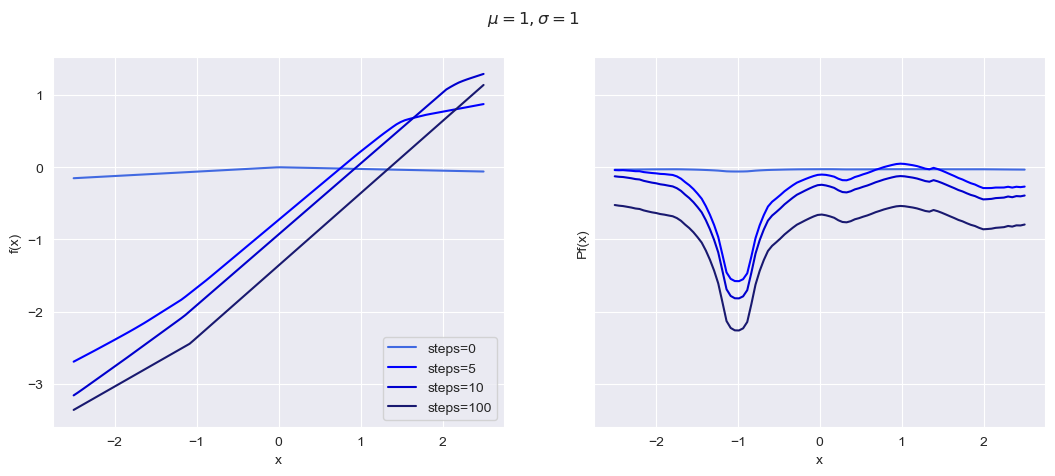

In [124]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True)
fig.suptitle(r"$\mu=1, \sigma=1$")

colors = ["royalblue", "blue", "mediumblue", "midnightblue"]

for step, fx, Pfx, color in zip(steps, fxs, Pfxs, colors):
    ax1.plot(x, fx, label=f"steps={step}", color=color)
    ax2.plot(x, Pfx, label=f"steps={step}", color=color)

ax1.legend(loc="lower right")

ax1.set_ylabel("f(x)")
ax2.set_ylabel("Pf(x)")
ax1.set_xlabel("x")
ax2.set_xlabel("x")

# fig.savefig(svg_dir + "sss-mixture-contraction-dual-m1.svg", format="svg")

# Lipschitz Property

In [9]:
rho_conf = dict(
    sample_batch_size=1000,
    n_train_batches=1, 
    n_eval_batches=1000,
    max_steps=1000,
    lr=0.1,
    ratio_rad=5,
)

In [10]:
%%time

x = jnp.linspace(-5, 5, 100)
X = x.reshape(-1, 1)

rng_key = random.PRNGKey(0)

scales = jnp.logspace(-1, 1, 9)
rwm_s_base = ARWMHAdaptState(jnp.array([0.0]), jnp.array([[1.0]]), jnp.array([[0.0]]))
rwm_s_comp = ARWMHAdaptState(jnp.array([0.0]), jnp.array([[0.1]]), jnp.array([[0.0]]))
n = 1
sample_P = lambda rng_key, x, n_samples: kernel_rwm_normal.sample_Pnx(rng_key, x, rwm_s_base, n, n_samples)
sample_Q = lambda rng_key, x, n_samples: kernel_rwm_normal.sample_Pnx(rng_key, x, rwm_s_comp, n, n_samples)
rho, model, params = compute_kernel_distance_1d(sample_P, sample_Q, rng_key, x, **rho_conf)

print(rho)

Train finished in 1000 steps. Last gradient norm: 0.4364958703517914.
0.544187
CPU times: user 2min 20s, sys: 8.45 s, total: 2min 28s
Wall time: 49.1 s


In [12]:
# import time
# time.sleep(3600)
# print("Time!")

In [11]:
rhos = []
for scale in scales:
    rwm_s_comp = ARWMHAdaptState(jnp.array([0.0]), scale.reshape(1,1), jnp.array([[0.0]]))
    sample_Q = lambda rng_key, x, n_samples: kernel_rwm_normal.sample_Pnx(rng_key, x, rwm_s_comp, n, n_samples)
    
    if rwm_s_comp == rwm_s_base:
        rho = jnp.array(0.0)
    else:
        rho, model, params = compute_kernel_distance_1d(sample_P, sample_Q, rng_key, x, **rho_conf)

    rhos.append(rho)

Train finished in 1000 steps. Last gradient norm: 0.4364958703517914.
Train finished in 1000 steps. Last gradient norm: 0.06295327097177505.
Train finished in 630 steps. Last gradient norm: 3.7607843922371487e-11.
Train finished in 494 steps. Last gradient norm: 6.181499756507947e-11.
Train finished in 318 steps. Last gradient norm: 8.620622271582334e-11.
Train finished in 688 steps. Last gradient norm: 8.527602235464116e-11.
Train finished in 315 steps. Last gradient norm: 8.259461170556648e-11.
Train finished in 192 steps. Last gradient norm: 8.363873482686301e-11.


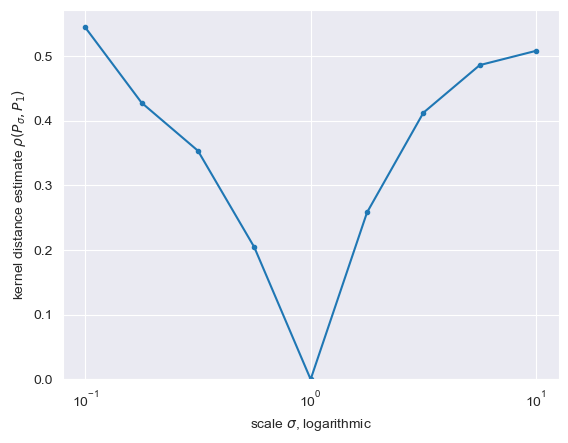

In [13]:
fig, ax = plt.subplots()

ax.plot(scales, rhos, ".-")
ax.semilogx()
ax.set_xlabel(r"scale $\sigma$, logarithmic")
ax.set_ylabel(r"kernel distance estimate $\rho(P_{\sigma}, P_{1})$")
ax.set_ylim(bottom=0)

plt.savefig(svg_dir + "rwm-normal-kernel-dist-scale.svg", format="svg")

In [14]:
x = jnp.linspace(-5, 5, 100)
X = x.reshape(-1, 1)

rng_key = random.PRNGKey(0)

scales = jnp.logspace(-1, 1, 9)
sss_s_base = ASSSAdaptState(jnp.array([0.]), jnp.array([[1.]]))
n = 1
sample_P = lambda rng_key, x, n_samples: kernel_sss_normal.sample_Pnx(rng_key, x, sss_s_base, n, n_samples)

rhos = []
for scale in scales:
    sss_s_comp = ASSSAdaptState(jnp.array([0.]), scale.reshape(1, 1))
    sample_Q  = lambda rng_key, x, n_samples: kernel_sss_normal.sample_Pnx(rng_key, x, sss_s_comp, n, n_samples)

    if sss_s_comp == sss_s_base:
        rho = jnp.array(0.0)
    else:
        rho, model, params = compute_kernel_distance_1d(sample_P, sample_Q, rng_key, x, **rho_conf)
    
    rhos.append(rho)

Train finished in 1000 steps. Last gradient norm: 0.08048988878726959.
Train finished in 1000 steps. Last gradient norm: 6.67759786665556e-06.
Train finished in 1000 steps. Last gradient norm: 4.628148531082843e-09.
Train finished in 640 steps. Last gradient norm: 6.034710231528351e-11.
Train finished in 162 steps. Last gradient norm: 9.505365938800026e-11.
Train finished in 332 steps. Last gradient norm: 9.561908209665404e-11.
Train finished in 268 steps. Last gradient norm: 7.563069615024176e-11.
Train finished in 401 steps. Last gradient norm: 7.87968718052312e-11.


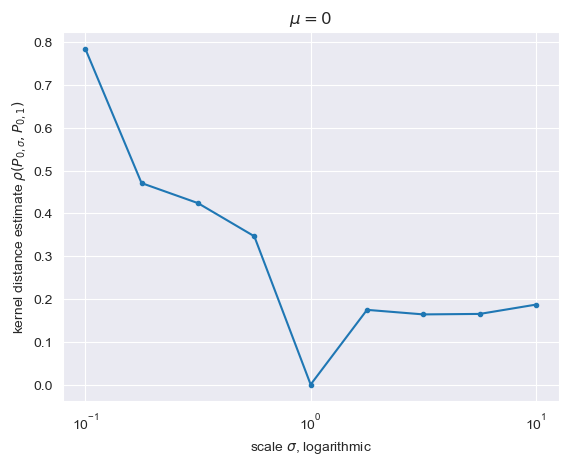

In [15]:
plt.plot(scales, rhos, ".-")
plt.semilogx()
plt.title(r"$\mu=0$")
plt.xlabel(r"scale $\sigma$, logarithmic")
plt.ylabel(r"kernel distance estimate $\rho(P_{0, \sigma}, P_{0, 1})$")

plt.savefig(svg_dir + "sss-normal-kernel-dist-scale.svg", format="svg")

In [16]:
x = jnp.linspace(-5, 5, 100)
X = x.reshape(-1, 1)

rng_key = random.PRNGKey(0)

locs = jnp.linspace(0, 1, 9)
sss_s_base = ASSSAdaptState(jnp.array([0.]), jnp.array([[1.]]))
n = 1
sample_P = lambda rng_key, x, n_samples: kernel_sss_normal.sample_Pnx(rng_key, x, sss_s_base, n, n_samples)

rhos = []
for loc in locs:
    sss_s_comp = ASSSAdaptState(loc[None], jnp.array([[1.]]))
    sample_Q  = lambda rng_key, x, n_samples: kernel_sss_normal.sample_Pnx(rng_key, x, sss_s_comp, n, n_samples)

    if sss_s_comp == sss_s_base:
        rho = jnp.array(0.0)
    else:
        rho, model, params = compute_kernel_distance_1d(sample_P, sample_Q, rng_key, x, **rho_conf)
    
    rhos.append(rho)

Train finished in 620 steps. Last gradient norm: 8.826728931099481e-11.
Train finished in 379 steps. Last gradient norm: 4.438032580322826e-11.
Train finished in 439 steps. Last gradient norm: 9.530796984957846e-11.
Train finished in 649 steps. Last gradient norm: 4.018979940512146e-11.
Train finished in 451 steps. Last gradient norm: 8.707259913087739e-11.
Train finished in 1000 steps. Last gradient norm: 2.4723398883708114e-09.
Train finished in 1000 steps. Last gradient norm: 3.856708730154423e-09.
Train finished in 1000 steps. Last gradient norm: 3.308007734403873e-08.


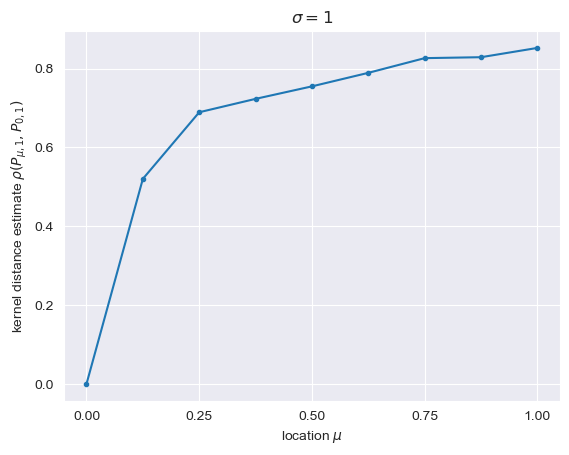

In [17]:
plt.plot(locs, rhos, ".-")
plt.title(r"$\sigma=1$")
plt.xticks(locs[::2])
plt.xlabel(r"location $\mu$")
plt.ylabel(r"kernel distance estimate $\rho(P_{\mu, 1}, P_{0, 1})$")


plt.savefig(svg_dir + "sss-normal-kernel-dist-loc.svg", format="svg")

In [18]:
x = jnp.linspace(-5, 5, 100)
X = x.reshape(-1, 1)

rng_key = random.PRNGKey(0)

scales = jnp.logspace(-1, 1, 9)
sss_s_base = ASSSAdaptState(jnp.array([1.]), jnp.array([[1.]]))
n = 1
sample_P = lambda rng_key, x, n_samples: kernel_sss_normal.sample_Pnx(rng_key, x, sss_s_base, n, n_samples)

rhos = []
for scale in scales:
    sss_s_comp = ASSSAdaptState(jnp.array([1.]), scale.reshape(1, 1))
    sample_Q  = lambda rng_key, x, n_samples: kernel_sss_normal.sample_Pnx(rng_key, x, sss_s_comp, n, n_samples)

    if sss_s_comp == sss_s_base:
        rho = jnp.array(0.0)
    else:
        rho, model, params = compute_kernel_distance_1d(sample_P, sample_Q, rng_key, x, **rho_conf)
    
    rhos.append(rho)

Train finished in 837 steps. Last gradient norm: 9.641288462036712e-11.
Train finished in 531 steps. Last gradient norm: 8.488279523710673e-11.
Train finished in 1000 steps. Last gradient norm: 2.1081016043922318e-08.
Train finished in 1000 steps. Last gradient norm: 0.0008910684264265001.
Train finished in 655 steps. Last gradient norm: 9.623545016435031e-11.
Train finished in 1000 steps. Last gradient norm: 0.0007330761291086674.
Train finished in 1000 steps. Last gradient norm: 0.001334905857220292.
Train finished in 1000 steps. Last gradient norm: 0.003709608456119895.


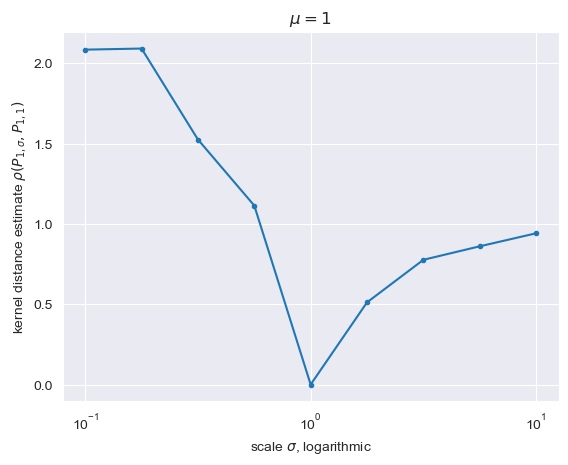

In [19]:
plt.plot(scales, rhos, ".-")
plt.semilogx()
plt.title(r"$\mu=1$")
plt.xlabel(r"scale $\sigma$, logarithmic")
plt.ylabel(r"kernel distance estimate $\rho(P_{1, \sigma}, P_{1, 1})$")

plt.savefig(svg_dir + "sss-normal-kernel-dist-scale-m1.svg", format="svg")